In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase

import warnings

from mpl_toolkits import mplot3d

from qutip import *

from ase.build import bulk

import pycce.filter

import scipy.stats as stats
from scipy.optimize import curve_fit

C:\Users\Daniel Low\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\Daniel Low\Anaconda3\lib\site-packages\qutip\__init__.py:61: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.12.
  .format(_cy_require, _Cython.__version__)


In [2]:
import matplotlib as mpl  
plt.style.use('plot_style.txt')
# mpl.rcParams['figure.figsize'] = [12.0, 8.0]
# mpl.rcParams['xtick.labelsize'] = 15


Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
"""set up seed for T2 calculation of varying concentration"""
seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
   T2_F_near  T2_err_F_near
0          1              1
1          2              2
2          3              3
3          4              4
4          5              5
5          6              6
6          7              7
7          8              8
8          9              9
9         10             10


Text(0, 0.5, '$T_2$ (ms)')

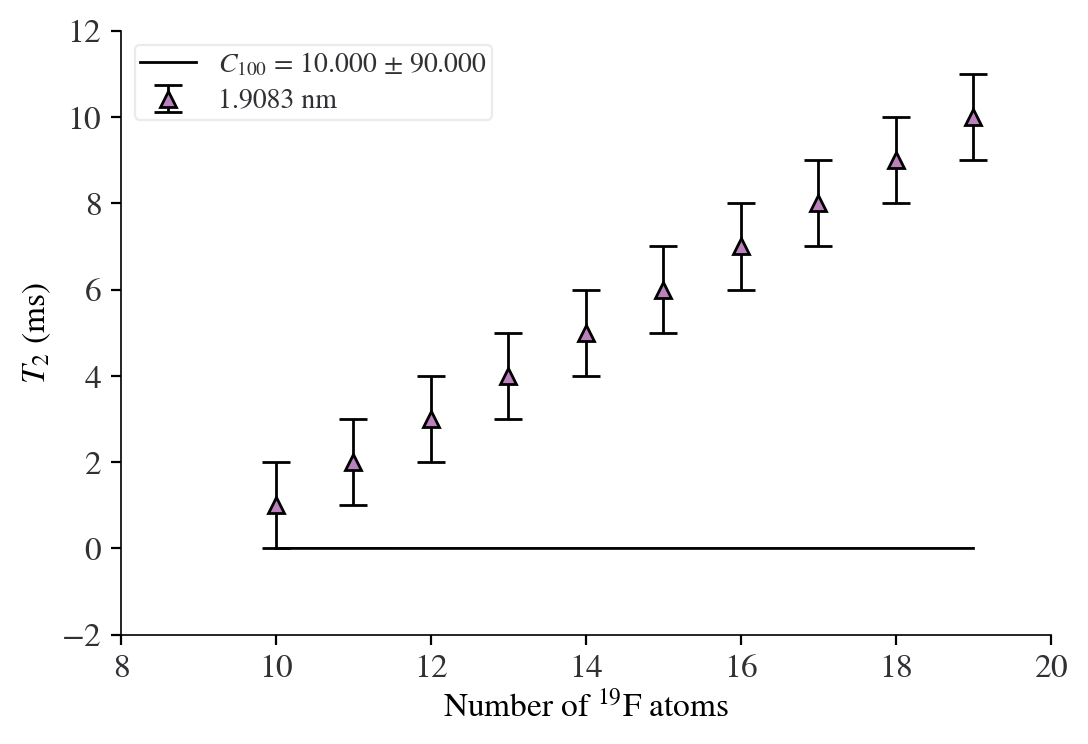

In [23]:
num = np.arange(10,20,1)
T2_F_near = [1,2,3,4,5,6,7,8,9,10]
# T2_F_near = np.array([1,2,3,4,5,6,7,8,9,10])
T2_err_F_near = [1,1,1,1,1,1,1,1,1,1]
print(T2_F_near)

k=10
p=90
desc = '$C_{100}$'

df = pd.DataFrame(data={'T2_F_near': T2_F_near, 'T2_err_F_near': T2_F_near})
print(df)
filepath = r'C:\Users\Daniel Low\Documents\Pin Work\Year 4\4th Year Physics Project\modelling codes\file3.csv'
# df.to_csv(filepath)

plt.figure()
plt.plot(num, 1/num**3, color='k', linewidth=1, label= desc+' = {0:0.3f} $\pm$ {1:0.3f}'.format(k,p))
plt.errorbar(num, T2_F_near, yerr=T2_err_F_near, fmt='^', ecolor='k', elinewidth=1, capsize=5, label='1.9083 nm')
# plt.errorbar(num, T2_F_mid , yerr=T2_err_F_mid , label='5.0 nm')
# plt.errorbar(num, T2_F_far , yerr=T2_err_F_far , label='8.0917 nm')
plt.legend()
plt.xlabel('Number of $^{19}$F atoms')
plt.ylabel('$T_2$ (ms)')

In [5]:

conc = np.arange(1e20,2.1e21,1e20)
num = np.arange(10,201,10)


#######################################################################################################################
########## depth = 1.9083 nm ##########
#######################################################################################################################
T2_F_near = []
T2_err_F_near = []
for j in conc:
    ''' generate layer of 10-200 hydrogens within a thin 10x10x1 nm^3 layer '''
    fluorine_layer = pc.random_bath('19F', [1e2, 1e2, 10], 
                                        density=j, density_units='cm-3', 
                                        center=[50,50,60], seed=seed)
    
    ''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
    # Generate unitcell from ase
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    
    # Add types of isotopes
    diamond.add_isotopes(('13C', 0.011))
    
    # Add the defect. remove and add atoms at the positions (in cell coordinates) 
    atoms = diamond.gen_supercell(100, remove=[('C', [-5, -5, -5]),('C', [-5+0.5, -5+0.5, -5+0.5])],
                                  add=('14N', [-5+0.5, -5+0.5, -5+0.5]), seed=seed)
    
    """setup for coherence calculation"""
    
    # Parameters of CCE calculations engine
    
    # Order of CCE aproximation
    order = 2
    # Bath cutoff radius
    r_bath = 150  # in A
    # Cluster cutoff radius
    r_dipole = 50  # in A
    
    # Qubit levels (in Sz basis)
    alpha = [0, 0, 1]; beta = [0, 1, 0]
    
    # ZFS Parametters of NV center in diamond
    D = 2.88 * 1e6 # in kHz
    E = 0 # in kHz
    
    # position of central spin
    position = [-5,-5,-5]
    
    # generate central spin
    nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)
    
    # Setting the runner engine
    calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,fluorine_layer]),
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "coherence calculation"
    
    "general"
    # Time points
    time_space = np.linspace(0, 3, 201)  # in ms
    
    # Mag. Field (Bx By Bz)
    b = np.array([0,0,500])  # in G
    
    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x', np.pi)]
    
    # Calculate coherence function with general method
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                 pulses=pulse_sequence,
                                 method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "fitting a negative squared exponential"
    def coherence_fit(x,T2):
        "fit coherence function to a negative squared exponential function with time constant T2"
        fit = np.exp(-(x/T2)**2)
        return fit
    
    #popt: Optimized parameters
    #pcov: matrix of covariance.
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    
    T2_F_near.append(T2_gen[0])
    T2_err_F_near.append(T2_var[0][0])
    
#######################################################################################################################
########## depth = 5.0 nm ##########
#######################################################################################################################
T2_F_mid = []
T2_err_F_mid = []
for j in conc:
    ''' generate layer of 10-300 hydrogens within a thin 10x10x1 nm^3 layer '''
    fluorine_layer = pc.random_bath('19F', [1e2, 1e2, 10], 
                                        density=j, density_units='cm-3', 
                                        center=[50,50,60], seed=seed)
    
    ''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
    # Generate unitcell from ase
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    
    # Add types of isotopes
    diamond.add_isotopes(('13C', 0.011))
    
    # Add the defect. remove and add atoms at the positions (in cell coordinates) 
    atoms = diamond.gen_supercell(100, remove=[('C', [0, 0, 0]),('C', [0+0.5, 0+0.5, 0+0.5])],
                                  add=('14N', [0+0.5, 0+0.5, 0+0.5]), seed=seed)
    
    """setup for coherence calculation"""
    
    # Parameters of CCE calculations engine
    
    # Order of CCE aproximation
    order = 2
    # Bath cutoff radius
    r_bath = 150  # in A
    # Cluster cutoff radius
    r_dipole = 50  # in A
    
    # Qubit levels (in Sz basis)
    alpha = [0, 0, 1]; beta = [0, 1, 0]
    
    # ZFS Parametters of NV center in diamond
    D = 2.88 * 1e6 # in kHz
    E = 0 # in kHz
    
    # position of central spin
    position = [0,0,0]
    
    # generate central spin
    nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)
    
    # Setting the runner engine
    calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,fluorine_layer]),
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "coherence calculation"
    
    "general"
    # Time points
    time_space = np.linspace(0, 3, 201)  # in ms
    
    # Mag. Field (Bx By Bz)
    b = np.array([0,0,500])  # in G
    
    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x', np.pi)]
    
    # Calculate coherence function with general method
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                 pulses=pulse_sequence,
                                 method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "fitting a negative squared exponential"
    def coherence_fit(x,T2):
        "fit coherence function to a negative squared exponential function with time constant T2"
        fit = np.exp(-(x/T2)**2)
        return fit
    
    #popt: Optimized parameters
    #pcov: matrix of covariance.
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    
    T2_F_mid.append(T2_gen[0])
    T2_err_F_mid.append(T2_var[0][0])

#######################################################################################################################
########## depth = 1.9083 nm ##########
#######################################################################################################################
T2_F_far = []
T2_err_F_far = []
for j in conc:
    ''' generate layer of 10-300 hydrogens within a thin 10x10x1 nm^3 layer '''
    fluorine_layer = pc.random_bath('19F', [1e2, 1e2, 10], 
                                        density=j, density_units='cm-3', 
                                        center=[50,50,60], seed=seed)
    
    ''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
    # Generate unitcell from ase
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    
    # Add types of isotopes
    diamond.add_isotopes(('13C', 0.011))
    
    # Add the defect. remove and add atoms at the positions (in cell coordinates) 
    atoms = diamond.gen_supercell(100, remove=[('C', [5, 5, 5]),('C', [5+0.5, 5+0.5, 5+0.5])],
                                  add=('14N', [5+0.5, 5+0.5, 5+0.5]), seed=seed)
    
    """setup for coherence calculation"""
    
    # Parameters of CCE calculations engine
    
    # Order of CCE aproximation
    order = 2
    # Bath cutoff radius
    r_bath = 150  # in A
    # Cluster cutoff radius
    r_dipole = 50  # in A
    
    # Qubit levels (in Sz basis)
    alpha = [0, 0, 1]; beta = [0, 1, 0]
    
    # ZFS Parametters of NV center in diamond
    D = 2.88 * 1e6 # in kHz
    E = 0 # in kHz
    
    # position of central spin
    position = [5,5,5]
    
    # generate central spin
    nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)
    
    # Setting the runner engine
    calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,fluorine_layer]),
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "coherence calculation"
    
    "general"
    # Time points
    time_space = np.linspace(0, 3, 201)  # in ms
    
    # Mag. Field (Bx By Bz)
    b = np.array([0,0,500])  # in G
    
    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x', np.pi)]
    
    # Calculate coherence function with general method
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                 pulses=pulse_sequence,
                                 method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "fitting a negative squared exponential"
    def coherence_fit(x,T2):
        "fit coherence function to a negative squared exponential function with time constant T2"
        fit = np.exp(-(x/T2)**2)
        return fit
    
    #popt: Optimized parameters
    #pcov: matrix of covariance.
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    
    T2_F_far.append(T2_gen[0])
    T2_err_F_far.append(T2_var[0][0])

# plots the data points and the fitted  curve
plt.figure()
plt.errorbar(num, T2_F_near, yerr=T2_err_F_near, label='1.9083 nm')
plt.errorbar(num, T2_F_mid , yerr=T2_err_F_mid , label='5.0 nm')
plt.errorbar(num, T2_F_far , yerr=T2_err_F_far , label='8.0917 nm')
plt.legend()
plt.xlabel('Number of $^{19}$F atoms')
plt.ylabel('$T_2$ (ms)')

C:\Users\Daniel Low\Anaconda3\lib\site-packages\pycce\run\clusters.py:172: RuntimeWarning: overflow encountered in power
  vcalc = contribution_operator(vcalc, current_power[index])
C:\Users\Daniel Low\Anaconda3\lib\site-packages\pycce\run\clusters.py:174: RuntimeWarning: invalid value encountered in multiply
  result = result_operator(result, vcalc)


KeyboardInterrupt: 

In [4]:


# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.0))
diamond.isotopes['C']['14C'] = 0.00

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(100, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]))

atoms['14C'].gyro = 0
atoms['14C'].spin = 0

"setup for coherence calculation"

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 1000  # in A
# Cluster cutoff radius
r_dipole = 1000  # in A

# position of central spin
position = [0,0,0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)



# electrons.from_point_dipole([0,0,70])

# Setting the runner engine
# mock = pc.Simulator(spin=nv,
#                     bath=np.concatenate([atoms,hydrogen]), r_bath=r_bath,
#                     r_dipole=r_dipole, order=order)

# calc = pc.Simulator(spin=nv, position=position, alpha=alpha, beta=beta,
#                     bath=electrons, r_bath=r_bath, magnetic_field=500, pulses=1,
#                     r_dipole=r_dipole, order=order)

# "scatter plot of points"

# # add 3D axis
# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(projection='3d')

# # We want to visualize the smaller bath
# data = mock.bath

# # First plot the positions of the bath
# colors = np.abs(data.A[:,2,2]/data.A[:,2,2].max())
# ax.scatter3D(data.x, data.y, data.z, c=colors, cmap='viridis');
# # Plot all pairs of nuclear spins, which are contained
# # in the calc.clusters dictionary under they key 2
# for c in mock.clusters[2]:
#     ax.plot3D(data.x[c], data.y[c], data.z[c], color='grey')
# # Plot all triplets of nuclear spins, which are contained
# # in the calc.clusters dictionary under they key 3
# for c in mock.clusters[3]:
#     ax.plot3D(data.x[c], data.y[c], data.z[c], color='red', ls='--', lw=0.5)

# ax.set(xlabel='x (A)', ylabel='y (A)', zlabel='z (A)');

## n = 20

In [5]:
fluorine = pc.random_bath('19F', [1e3, 1e3, 20], density=1e18,
                        density_units='cm-3', center=[500,500,70], seed=seed)

print(fluorine.size)

# fluorine.zdir = [1,1,1]

20


In [6]:
# Setting the runner engine
calc = pc.Simulator(spin=nv,
                    bath=np.concatenate([atoms,fluorine]), r_bath=r_bath,
                    r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space_20 = np.linspace(0, 50000, 101)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

l_conv = calc.compute(time_space_20, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space_20, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 40

# Calculate coherence function
l_gcce = calc.compute(time_space_20, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space_20, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space_20, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)





popt_gen :
 [1.]
pcov_gen :
 [[inf]]
popt_samp :
 [1.]
pcov_samp :
 [[inf]]


C:\Users\Daniel Low\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0, 0.5, 'Coherence')

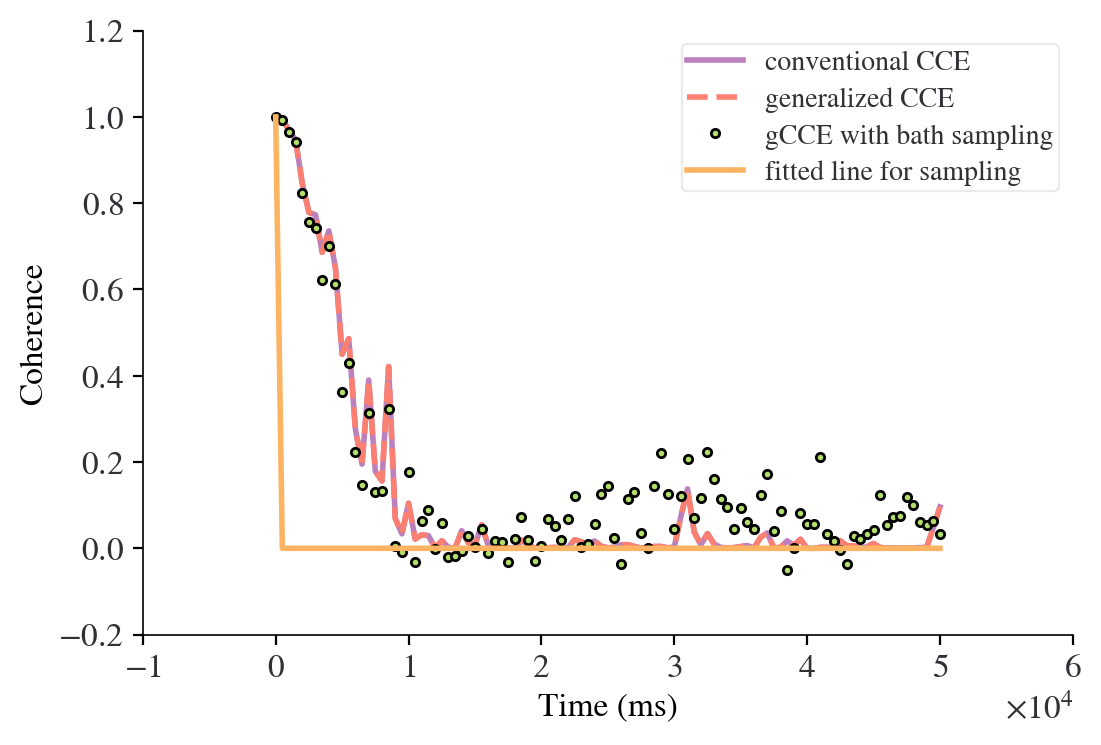

In [7]:
T2_gen_20 = popt1
T2_samp_20 = popt2

y_gen_20 = coherence_fit(time_space_20, 8000)   # calculates the y value using the Gaussian function
y_samp_20 = coherence_fit(time_space_20, T2_samp_20)

conv_20 = l_conv.real
gen_20 = l_generatilze.real
genbath_20 = l_gcce.real

# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space_20, conv_20,
         label='conventional CCE')
plt.plot(time_space_20, gen_20,
         label='generalized CCE', ls='--')
plt.plot(time_space_20, genbath_20,
         label='gCCE with bath sampling', ls='', marker='.')


# plt.plot(time_space,y_gen,'-', label='fitted line for general')
plt.plot(time_space_20,y_samp_20,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
# plt.yscale('log')
#plt.title("fitted line to the calculated coherence decay")


## n = 200

In [8]:
fluorine = pc.random_bath('19F', [1e3, 1e3, 20], density=1e19,
                        density_units='cm-3', center=[500,500,70], seed=seed)

print(fluorine.size)

# fluorine.zdir = [1,1,1]

200


In [11]:
# Setting the runner engine
calc = pc.Simulator(spin=nv,
                    bath=np.concatenate([atoms,fluorine]), r_bath=r_bath,
                    r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space_200 = np.linspace(0, 1500, 101)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

l_conv = calc.compute(time_space_200, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space_200, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 40

# Calculate coherence function
l_gcce = calc.compute(time_space_200, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**3)
    
    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space_200, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space_200, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)







popt_gen :
 [1.]
pcov_gen :
 [[inf]]
popt_samp :
 [1.]
pcov_samp :
 [[inf]]


Text(0, 0.5, 'Coherence')

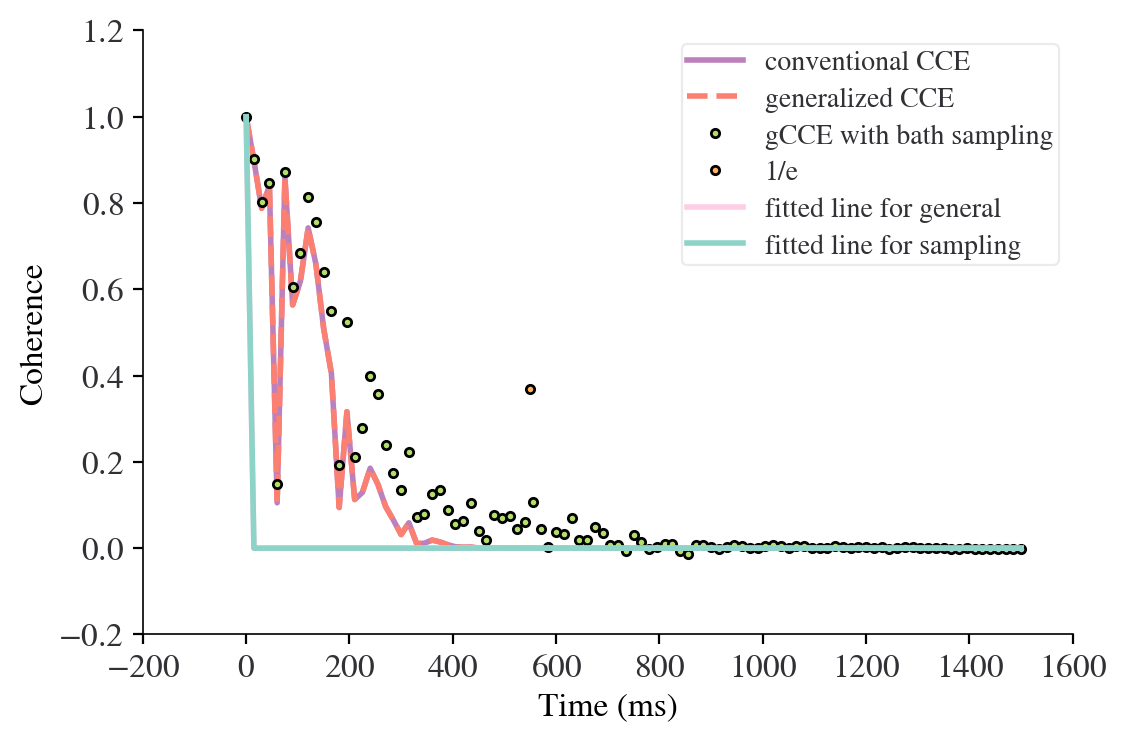

In [12]:
T2_gen_200 = popt1
T2_samp_200 = popt2

y_gen_200 = coherence_fit(time_space_200, T2_gen_200)   # calculates the y value using the Gaussian function
y_samp_200 = coherence_fit(time_space_200, T2_samp_200)

conv_200 = l_conv.real
gen_200 = l_generatilze.real
genbath_200 = l_gcce.real

# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space_200, conv_200,
         label='conventional CCE')
plt.plot(time_space_200, gen_200,
         label='generalized CCE', ls='--')
plt.plot(time_space_200, genbath_200,
         label='gCCE with bath sampling', ls='', marker='.')

plt.plot([550], [1/np.exp(1)],
         label='1/e', ls='', marker='.')

plt.plot(time_space_200,y_gen_200,'-', label='fitted line for general')
plt.plot(time_space_200,y_samp_200,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
# plt.yscale('log')
#plt.title("fitted line to the calculated coherence decay")
